# Predict interval boundaries on kss audio

In [207]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import IPython
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

import logging

class Log:
    @staticmethod
    def set(log_name):
        logger = logging.getLogger(log_name)
        if logger.hasHandlers():
            logger.handlers.clear()
        c_handler = logging.StreamHandler()
        c_format = logging.Formatter('%(name)s[%(levelname)s]: %(message)s')
        c_handler.setFormatter(c_format)
        logger.addHandler(c_handler)
        logger.setLevel(logging.DEBUG)
        return logger

# def setClassLogger(cls):
#     cls.log = property(lambda self: logging.getLogger(self.__class__.__name__))
# Create a base class
# class LoggingHandler:
#     def __init__(self, *args, **kwargs):
#         self.log = logging.getLogger(self.__class__.__name__)



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


## Data Preparation
Create features


## Audio Info

Informational:
* Consonant Phonemes duration 25-50 msec
* Vowel Phonemes duration 50-100+ msec


## Character and Syllable Chunk Markers

In [2]:
# Handles Dataframe related actions.
# The first column of the dataframe is the marker type
#   for example 'char' or 'syl'
# Dataframe must have the following columns
# start, stop, audio
# NOTE: The audio column is the path to the audio wav file for the other columns

class MarkerDf:

    @classmethod
    def read_csv(cls, csv_f):
        return cls(pd.read_csv(csv_f))

    def __init__(self, df):
        self.df = df

    def intervals(self):
        return self.df['stop'] - self.df['start']

    def display(self):
        display(self.df)

    def audio_files(self):
        return self.df['audio'].unique()

    def markers_by_file(self, cols=None):
        if cols == None:
            cols = self.df.columns
        dict = {}
        for f in self.audio_files():
            col_dict = {}
            for col in cols:
                col_dict[col] = self.df[self.df['audio'] == f][col].values
            dict[f] = col_dict
        return dict






In [3]:
chunk_dir = 'data/korean-single-speaker/kss_chunks'

markers_char = MarkerDf.read_csv(f'{chunk_dir}/chunk_char.csv')
markers_syl = MarkerDf.read_csv(f'{chunk_dir}/chunk_syl.csv')

# below is deprecated
chunk_char_df = pd.read_csv(f'{chunk_dir}/chunk_char.csv')
chunk_syl_df = pd.read_csv(f'{chunk_dir}/chunk_syl.csv')

## Event Marker Analysis



### Event Marker Statistics

#### Intervals

In [4]:
print('Char Interval statistics')
print(markers_char.intervals().describe())
print('')
print('Syl Interval statistics')
print(markers_syl.intervals().describe())


Char Interval statistics
count    133.000000
mean       0.086957
std        0.061730
min        0.006800
25%        0.044530
50%        0.073060
75%        0.113300
max        0.312600
dtype: float64

Syl Interval statistics
count    72.000000
mean      0.160629
std       0.079553
min       0.012280
25%       0.100855
50%       0.158450
75%       0.219373
max       0.336930
dtype: float64


## Event Marker Data

Dictionary of audio_file -> list of event marker times.

In [5]:
markers_char.display()
markers_syl.display()

# Below is deprecated
display(chunk_char_df)
display(chunk_syl_df)

,char,start,stop,audio
0,0,0.00000,0.14298,data/korean-single-speaker/kss/1/1_0000.wav
1,ᄀ,0.14298,0.17326,data/korean-single-speaker/kss/1/1_0000.wav
2,ᅳ,0.17326,0.25143,data/korean-single-speaker/kss/1/1_0000.wav
3,ᆫ,0.25143,0.30110,data/korean-single-speaker/kss/1/1_0000.wav
4,ᅳ,0.30110,0.39456,data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...
128,ᅵ,1.78153,1.83571,data/korean-single-speaker/kss/1/1_0003.wav
129,ᆫ,1.83571,1.97293,data/korean-single-speaker/kss/1/1_0003.wav
130,ᄃ,1.97293,1.98396,data/korean-single-speaker/kss/1/1_0003.wav
131,ᅡ,1.98396,2.19790,data/korean-single-speaker/kss/1/1_0003.wav


,syl,start,stop,audio
0,0,0.00000,0.14298,data/korean-single-speaker/kss/1/1_0000.wav
1,그,0.14298,0.25143,data/korean-single-speaker/kss/1/1_0000.wav
2,는,0.25143,0.49473,data/korean-single-speaker/kss/1/1_0000.wav
3,0,0.49473,0.52397,data/korean-single-speaker/kss/1/1_0000.wav
4,괜,0.52397,0.71846,data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...
67,이,1.45550,1.53270,data/korean-single-speaker/kss/1/1_0003.wav
68,아,1.53270,1.75352,data/korean-single-speaker/kss/1/1_0003.wav
69,낀,1.75352,1.97293,data/korean-single-speaker/kss/1/1_0003.wav
70,다,1.97293,2.19790,data/korean-single-speaker/kss/1/1_0003.wav


,char,start,stop,audio
0,0,0.00000,0.14298,data/korean-single-speaker/kss/1/1_0000.wav
1,ᄀ,0.14298,0.17326,data/korean-single-speaker/kss/1/1_0000.wav
2,ᅳ,0.17326,0.25143,data/korean-single-speaker/kss/1/1_0000.wav
3,ᆫ,0.25143,0.30110,data/korean-single-speaker/kss/1/1_0000.wav
4,ᅳ,0.30110,0.39456,data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...
128,ᅵ,1.78153,1.83571,data/korean-single-speaker/kss/1/1_0003.wav
129,ᆫ,1.83571,1.97293,data/korean-single-speaker/kss/1/1_0003.wav
130,ᄃ,1.97293,1.98396,data/korean-single-speaker/kss/1/1_0003.wav
131,ᅡ,1.98396,2.19790,data/korean-single-speaker/kss/1/1_0003.wav


,syl,start,stop,audio
0,0,0.00000,0.14298,data/korean-single-speaker/kss/1/1_0000.wav
1,그,0.14298,0.25143,data/korean-single-speaker/kss/1/1_0000.wav
2,는,0.25143,0.49473,data/korean-single-speaker/kss/1/1_0000.wav
3,0,0.49473,0.52397,data/korean-single-speaker/kss/1/1_0000.wav
4,괜,0.52397,0.71846,data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...
67,이,1.45550,1.53270,data/korean-single-speaker/kss/1/1_0003.wav
68,아,1.53270,1.75352,data/korean-single-speaker/kss/1/1_0003.wav
69,낀,1.75352,1.97293,data/korean-single-speaker/kss/1/1_0003.wav
70,다,1.97293,2.19790,data/korean-single-speaker/kss/1/1_0003.wav


In [6]:
print(markers_char.markers_by_file(['stop']))
print(markers_syl.markers_by_file(['stop']))
# Below is deprecated
char_event_stop_dict = {}
syl_event_stop_dict = {}
audio_files_char = chunk_char_df['audio'].unique()
audio_files_syl = chunk_syl_df['audio'].unique()

# List of the unique audio file path/names
audio_files = np.unique(np.concatenate((audio_files_char, audio_files_syl)))

for audio_file in audio_files:
    char_stop_events = chunk_char_df[chunk_char_df['audio'] == audio_file]['stop'].values
    syl_stop_events = chunk_syl_df[chunk_syl_df['audio'] == audio_file]['stop'].values
    char_event_stop_dict[audio_file] = char_stop_events
    syl_event_stop_dict[audio_file] = syl_stop_events

print(char_event_stop_dict)
print(syl_event_stop_dict)

{'data/korean-single-speaker/kss/1/1_0000.wav': {'stop': array([0.14298, 0.17326, 0.25143, 0.3011 , 0.39456, 0.49473, 0.52397,
       0.5717 , 0.66385, 0.71846, 0.73074, 0.7928 , 0.86105, 0.8947 ,
       0.94568, 0.98747, 1.00429, 1.05658, 1.12825, 1.20548, 1.24674,
       1.27921, 1.33187, 1.35667, 1.50828, 1.54819, 1.5778 , 1.73609,
       2.04869, 2.15518, 2.28461, 2.3443 , 2.37857, 2.45163, 2.53042,
       2.55297, 2.61609, 2.63233, 2.68239, 2.7029 , 2.76329, 2.86374,
       2.8825 , 2.95272, 3.14772, 3.1583 , 3.4173 , 3.52653])}, 'data/korean-single-speaker/kss/1/1_0001.wav': {'stop': array([0.0927 , 0.12765, 0.17218, 0.2192 , 0.2473 , 0.41173, 0.50644,
       0.57461, 0.59243, 0.64042, 0.70654, 0.81835, 0.83326, 0.95153,
       1.09444, 1.11834, 1.20856, 1.37623, 1.59665, 1.64288, 1.76991,
       1.89271, 1.99178, 2.06911, 2.15357, 2.19706, 2.26984, 2.40939,
       2.50919, 2.78858, 2.85241, 2.89864, 2.99798, 3.0465 , 3.09567,
       3.16021, 3.20729, 3.33246, 3.50541, 3.52027, 3

## Audio Data

* X - audio wav file
* y - time to next boundary
  * Given X and the event stop times
DF

i_start, i_stop, i_midpoint, event_offset, audio_dur, audio

### Windowing

#### Window Size
The window size (in seconds) is used to segment the audio file data into sections of identical length (the window size)

#### Window Stride
The window stride (in seconds) determines when each window starts.
* when stride == size then the windows do not overlap
* when stride < size then the windows will have overlapping audio sections
* when stride > size there there will be audio gaps between windows


In [7]:
window_size_s = 0.3
# window_stride_s = 0.005


## Feature Prep

X is slices of audio with window_size_s duration

y is valid_event boolean

TODO: Normalize the data across audio files

In [208]:
# pad = (math.ceil(w / hop_length) * hop_length) - w
# print(f'pad: {pad}')
# w_padded = w + pad
# print(f'wav size padded {w_padded}')
# print(f'modulo hop_length: {w_padded % hop_length}')
# print(f'reduced: {w_padded/hop_length}')

import math

# Create a custom logger


#
class Audio():

    def __init__(self, path, sr=None, n_fft=256, n_hops=4):
        self.log = Log.set(self.__class__.__name__)
        self.n_fft = n_fft
        self.n_hops = n_hops
        self.hop_length = math.ceil(self.n_fft/self.n_hops)
        self.path = path
        wav_, sr_ = librosa.load(self.path, sr=sr)
        nice_size = math.floor(len(wav_) / self.hop_length) * self.hop_length
        if nice_size != len(wav_):
            delta = nice_size - len(wav_)
            self.log.warning(f'Modifying input wav from size {len(wav_)} to {nice_size}')
            self.log.info(f'change in number of samples: {delta} [should be less than hop length: {self.hop_length}]')
            assert(delta <= self.hop_length)
        wav_ = wav_[0:nice_size-1]

        # if memory performance becomes a constraint we can skip setting the wav in the constructor
        # and move it into a method instead
        self.wav = librosa.util.normalize(wav_)
        self.mfcc = librosa.feature.mfcc(y=self.wav, sr=sr_, n_mfcc=12, n_fft=n_fft, hop_length=self.hop_length)
        self.rms = self.to_rms(self.wav)
        self.sr = sr_
        self.size = len(self.wav)

    def to_idx(self, t):
        return math.ceil(self.sr * t)

    def to_rms(self, x):
        rms = librosa.feature.rms(y=x, frame_length=self.n_fft, hop_length=self.hop_length)
        print(f'a.to_rms size: {rms.shape[1]}, reduced {(len(x)/self.n_fft)*self.n_hops}')
        return librosa.util.normalize(rms, axis=1)


    # Return numpy array matching audio size
    def val_from_interval(self, df, ivl_cols=['start', 'stop'], val_col='value', missing_val=None):
        vals = np.full(self.size, missing_val)
        ivl_df = (df.loc[:,ivl_cols] * self.sr).apply(np.ceil).astype(int)
        ivl_df[val_col] = df.loc[:,val_col]
        for (start, stop, val) in ivl_df.values:
            vals[start:stop] = val
        return vals

,start,stop,syl,audio,value
47,0.00000,0.04262,0,data/korean-single-speaker/kss/1/1_0002.wav,False
48,0.04262,0.26336,용,data/korean-single-speaker/kss/1/1_0002.wav,True
49,0.26336,0.34202,0,data/korean-single-speaker/kss/1/1_0002.wav,False
50,0.34202,0.49675,돈,data/korean-single-speaker/kss/1/1_0002.wav,True
51,0.49675,0.71494,을,data/korean-single-speaker/kss/1/1_0002.wav,True
52,0.71494,0.87711,0,data/korean-single-speaker/kss/1/1_0002.wav,False
53,0.87711,0.99477,아,data/korean-single-speaker/kss/1/1_0002.wav,True
54,0.99477,1.07471,0,data/korean-single-speaker/kss/1/1_0002.wav,False
55,1.07471,1.21377,껴,data/korean-single-speaker/kss/1/1_0002.wav,True
56,1.21377,1.45645,써,data/korean-single-speaker/kss/1/1_0002.wav,True


Audio[WARNING]: Modifying input wav from size 77573 to 77568
Audio[INFO]: change in number of samples: -5 [should be less than hop length: 64]
/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


a.to_rms size: 1212, reduced 1211.984375
audio length: 77567
a.to_rms size: 1212, reduced 1211.984375
y shape: (77567,)
y_rms shape: (1, 1212)
mfcc shape: (12, 1212)
rms shape: (1, 1212)


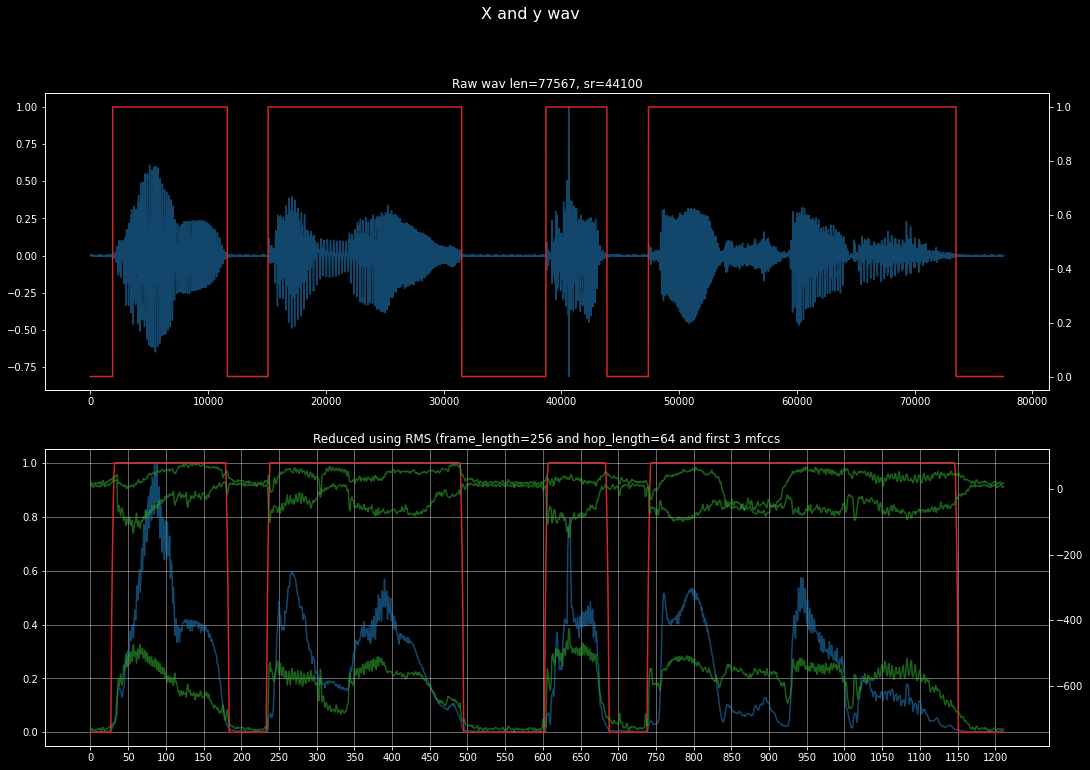

In [209]:
# Explore the data using the Audio Class

audio_path_ = 'data/korean-single-speaker/kss/1/1_0002.wav'
audio_syl_df_ = chunk_syl_df.loc[chunk_syl_df['audio'] == audio_path_,['start', 'stop', 'syl', 'audio']]
audio_syl_df_['value'] = audio_syl_df_['syl'] != '0'
display(audio_syl_df_)

a = Audio(audio_path_, n_fft=256, n_hops=4)
print(f'audio length: {a.size}')

y = a.val_from_interval(audio_syl_df_, missing_val=False)
y_rms = a.to_rms(y.astype(float))

print(f'y shape: {y.shape}')
print(f'y_rms shape: {y_rms.shape}')
print(f'mfcc shape: {a.mfcc.shape}')
print(f'rms shape: {a.rms.shape}')


fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(18,12))
fig.suptitle('X and y wav', fontsize=16)

ax1.set_title(f'Raw wav len={a.size}, sr={a.sr}')
ax1.plot(a.wav, color='tab:blue', alpha=0.6)
ax1a = ax1.twinx()
ax1a.plot(y, color='tab:red', alpha=1)

ax2.set_title(f'Reduced using RMS (frame_length={a.n_fft} and hop_length={a.hop_length} and first 3 mfccs')
ax2.plot(a.rms.flatten(), color='tab:blue', alpha=0.6)
ax2a = ax2.twinx()
ax2a.plot(a.mfcc[0], color='tab:green', alpha=0.6)
ax2a.plot(a.mfcc[1], color='tab:green', alpha=0.6)
ax2a.plot(a.mfcc[2], color='tab:green', alpha=0.6)

ax2.plot(y_rms.flatten(), color='tab:red', alpha=1)
ax2.grid(alpha=0.5)
ax2.xaxis.set_ticks(np.arange(0, len(a.rms.flatten()), 50))

plt.show()

In [164]:
# # Audio init: wav size: 175173, pad factor 0.0
# # a.to_rms size: 2738, reduced 2737.078125
# w = 175173
# n_fft = 256
# n_hops = 4
# hop_length_f = n_fft/n_hops
# hop_length = math.ceil(hop_length_f)
# n_fft2 = hop_length * n_hops
# print(f'wav size {w}')
# print(f'hop length int : float : {hop_length} : {hop_length_f}')
# print(f'n_fft : nfft2: {n_fft} : {n_fft2}')
# print(f'modulo hop_length: {w % n_fft2}')
# reduced_len = w/hop_length
# print(f'reduced: {reduced_len}')
# print('---- padding calcs ----')
# print(f'Need to pad to: {math.ceil(reduced_len) * hop_length}')
# pad = (math.floor(w / hop_length) * hop_length) - w
# print(f'pad: {pad}')
# w_padded = w + pad
# print(f'wav size padded {w_padded}')
# print(f'modulo hop_length: {w_padded % hop_length}')
# print(f'reduced: {w_padded/hop_length}')



wav size 175173
hop length int : float : 64 : 64.0
n_fft : nfft2: 256 : 256
modulo hop_length: 69
reduced: 2737.078125
---- padding calcs ----
Need to pad to: 175232
pad: -5
wav size padded 175168
modulo hop_length: 0
reduced: 2737.0


In [211]:
import wave


# Handles time to samples conversion so it is consistent for all instances
class AudioPlexer:

    # Will verify the wav_files all have the specified sample rate
    # if sample rate is not provided, use the first wav file's sample rate.

    # PERFORMANCE NOTE: We're storing the raw wav file
    def __init__(self, audio_paths, sr=None, n_fft=256, n_hops=4):
        self.audio_paths = audio_paths
        self.sr = sr
        self.n_fft = n_fft
        self.n_hops = n_hops
        self.hop_length = math.ceil(self.n_fft/self.n_hops)

        # validate all files have the same sample rate
        for fn in self.audio_paths:
            with wave.open(fn, 'rb') as f:
                sr_ = f.getframerate()
                if self.sr is None:
                    self.sr = sr_
                assert self.sr == sr_

        self.audios = [Audio(f, sr=self.sr, n_fft=self.n_fft, n_hops=n_hops) for f in self.audio_paths]
        self.size = sum([a.size for a in self.audios])

    def wav(self):
        return np.concatenate([a.wav for a in self.audios])

    def mfcc(self):
        return np.concatenate([a.mfcc for a in self.audios], axis=1)

    def rms(self):
        return np.concatenate([a.rms for a in self.audios], axis=1)

    # Return numpy array matching audio size
    def val_from_interval(self, df, ivl_cols=['start', 'stop'], val_col='value', missing_val=None):
        a_dfs = [self.df_per_audio(df, a.path, val_col='syl') for a in self.audios]
        kw = {'ivl_cols':ivl_cols, 'val_col':val_col, 'missing_val':missing_val}

        # TODO Pad the result to be an even factor of n_fft * hop_length
        return np.concatenate([a.val_from_interval(a_df , **kw) for (a_df, a) in zip(a_dfs, self.audios)])

    def df_per_audio(self, full_a_df, audio_path, val_col='syl'):
        a_df = full_a_df.loc[full_a_df['audio'] == audio_path,['start', 'stop', val_col, 'audio']]
        a_df['value'] = a_df[val_col] != '0'
        return a_df

    def to_rms(self, x):
        rms = librosa.feature.rms(y=x, frame_length=self.n_fft, hop_length=self.hop_length)
        return librosa.util.normalize(rms, axis=1)


In [ ]:
ap = AudioPlexer(audio_files)
print(f'all audio length (wav samples) {ap.size}, duration: {ap.size/ap.sr}')
# display(audio_syl_df_)
y = ap.val_from_interval(chunk_syl_df, missing_val=False)
y_rms = ap.to_rms(y.astype(float))
y_mfcc = ap.mfcc()

print(f'wav shape: {ap.wav().shape}')
print(f'y shape: {y.shape}')
print(f'y_rms shape: {y_rms.shape}')
print(f'mfcc shape: {y_mfcc.shape}')
print(f'rms shape: {ap.rms().shape}')


fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(18,12))
fig.suptitle('Full X and y wav', fontsize=16)

ax1.set_title(f'Raw wav len={ap.size}, sr={ap.sr}')
ax1.plot(ap.wav(), color='tab:blue', alpha=0.6)
ax1a = ax1.twinx()
ax1a.plot(y, color='tab:red', alpha=1)
ax2.set_title(f'Reduced using RMS (frame_length={a.n_fft} and hop_length={a.hop_length}')
ax2.plot(ap.rms().flatten(), color='tab:blue', alpha=0.6)
ax2.plot(y_rms.flatten(), color='tab:red', alpha=1)

ax2a.plot(y_mfcc[0], color='tab:green', alpha=0.6)
ax2a.plot(y_mfcc[1], color='tab:green', alpha=0.6)
ax2a.plot(y_mfcc[2], color='tab:green', alpha=0.6)
ax2.grid(alpha=0.5)
ax2.xaxis.set_ticks(np.arange(0, len(ap.rms().flatten()), 400))
plt.show()



In [88]:
import math
from keras.preprocessing.sequence import pad_sequences
from scipy import stats
from sklearn.utils import shuffle


audio_dict = {}

def t_to_samps(sr, t):
    return int(math.ceil(t * sr))

def calc_dist_to_stop(wav, sr, stop_times):
    # index to track the current stop_time
    stop_idx = 0
    dist_to_stop = np.zeros(wav.shape).astype(int)
    for i in range(wav.shape[0]):
        dist = t_to_samps(sr, stop_times[stop_idx]) - i
        if dist < 0:
            stop_idx += 1
            dist = t_to_samps(sr, stop_times[stop_idx]) - i
        if dist < 0:
            raise Exception('Unable to calculate distace t next stop time')
        dist_to_stop[i] = dist
    return dist_to_stop

X = np.array([])
y = np.array([])
sr = None
for fn in audio_files:
    wav, sr = librosa.load(fn)
    # wav = np.pad(wav, int(window_size_s*sr), 'edge')
    dist_to_stop = calc_dist_to_stop(wav, sr, syl_event_stop_dict[fn])
    # audio_dict[fn] = {'sr': sr, 'wav': wav, 'dist_to_stop': dist_to_stop}
    X = np.concatenate([X, wav])
    sr = sr
    y = np.concatenate([y, dist_to_stop])
X=X.flatten()
print(X.shape)
print (y.shape)



(255015,)
(255015,)


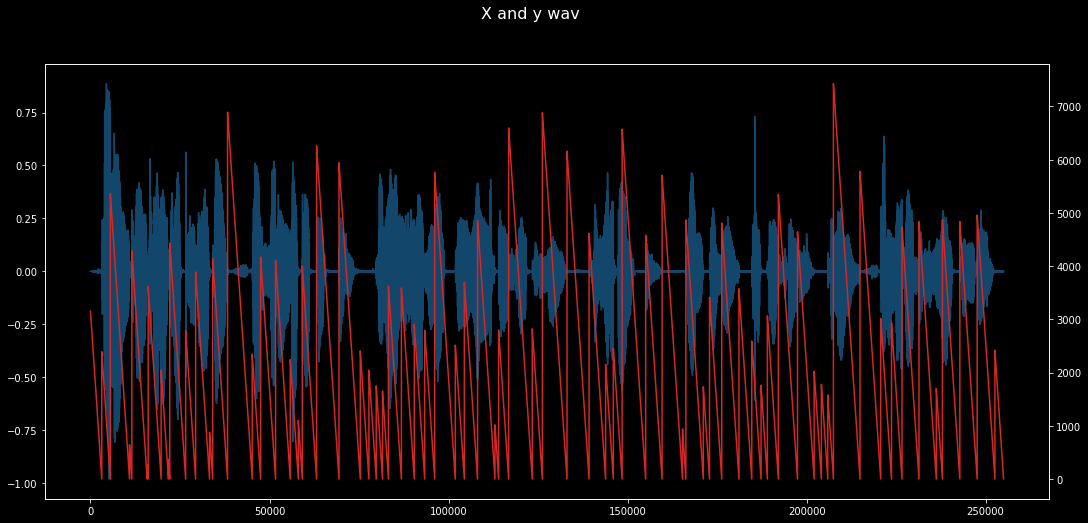

In [89]:
#
fig, ax1  = plt.subplots(figsize=(18,8))
fig.suptitle('X and y wav', fontsize=16)
# ax1.plot(np.max(X, axis=0))
ax1.plot(X, color='tab:blue', alpha=0.6)
ax2 = ax1.twinx()
ax2.plot(y, color='tab:red', alpha=1)
# ax1.scatter(x_, np.concatenate(X), alpha=1)
# ax1.scatter(x_, y-0.5, alpha=0.25)
plt.show()


## CNN Model

In [90]:

from keras.models import Sequential
from keras import layers

from keras.optimizers import RMSprop

print(X.shape)
print(y.shape)
seq_length = int(math.ceil(window_size_s * sr))
truncate_by = X.shape[0] % seq_length
X = X[0:-truncate_by]
y[0:-truncate_by]
print(truncate_by)
print(seq_length)
print(X.shape)
print(y.shape)

(255015,)
(255015,)
3645
6615
(251370,)
(255015,)


In [91]:
from keras.optimizers import Adam

num_features = 1
X = X.reshape(-1, seq_length, 1)
print(X.shape)
print(y.shape)

#parameters
kernel_size = 8
batch_size = 256
epochs = 40
# optimizer=RMSprop(lr=1e-4)
# optimizer='rmsprop'
optimzer = Adam(learning_rate=1e-4)
strides=16


model = Sequential()
# model.add(layers.Embedding(X.shape[0], kernel_size, input_length=input_length))
model.add(layers.Conv1D(1024, kernel_size, activation='relu', strides=strides, input_shape=(seq_length, num_features)))
model.add(layers.AveragePooling1D(24))
model.add(layers.Conv1D(2048, kernel_size, activation='relu', strides=strides))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='linear'))

model.summary()

model.compile(optimizer=optimizer,
              loss='mean_absolute_error',
              metrics=['mean_absolute_error', 'acc'])

history = model.fit(X, y,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2)


(38, 6615, 1)
(255015,)
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 413, 1024)         9216      
_________________________________________________________________
average_pooling1d_16 (Averag (None, 17, 1024)          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 1, 2048)           16779264  
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 2049      
Total params: 16,790,529
Trainable params: 16,790,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 3s 3s/step - loss: 3138.5000 - me

RNN Model

In [ ]:
# # Parameters
# timesteps = 8
# # optimizer=RMSprop(lr=1e-4)
# optimizer='rmsprop'
#
#
# # Model Input
# features = X.shape[1]
# input_shape = (timesteps, features)
#
# model = Sequential()
# model.add(layers.LSTM(32, input_shape=input_shape, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))
#
# model.summary()
#
# model.compile(optimizer=optimizer,
#               loss='binary_crossentropy',
#               metrics=['acc'])
#
# history = model.fit(X, y,
#                     epochs=10,
#                     batch_size=16,
#                     validation_split=0.2)

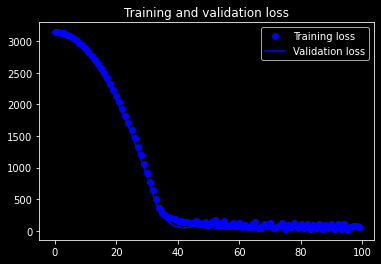

In [67]:
# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
#
# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [72]:
# print(X)
X_test = X[[15, 25]]
print(X_test.shape)
y_test = model.predict_classes(X_test)
#
# print(y_test.reshape(1,-1))

print(y_test.shape)
print(y_test)

(2, 6615, 1)
(2, 1)
[[1]
 [1]]


/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


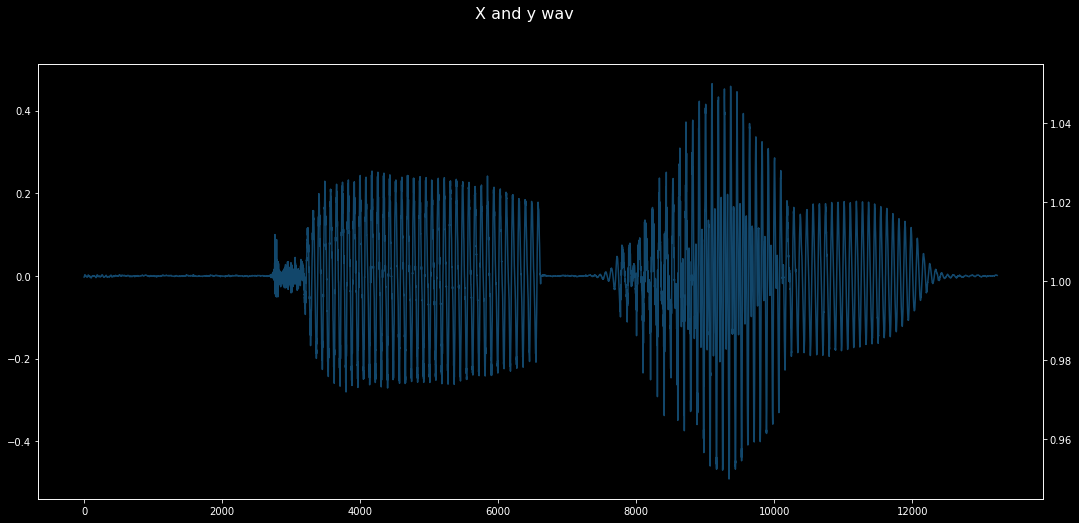

In [71]:
fig, ax1  = plt.subplots(figsize=(18,8))
fig.suptitle('X and y wav', fontsize=16)
# ax1.plot(np.max(X, axis=0))
ax1.plot(X_test.flatten(), color='tab:blue', alpha=0.6)
ax2 = ax1.twinx()
ax2.plot(y_test.flatten(), color='tab:red', alpha=1)
# ax1.scatter(x_, np.concatenate(X), alpha=1)
# ax1.scatter(x_, y-0.5, alpha=0.25)
plt.show()




In [ ]:
# data_files = chunk_char_df['audio'].unique()
# sr_ = None
# audio_ = None
# for wv in data_files:
#     fn = f'{wv}'
#     print(f'Data file to analyze: {fn}')
#     print(f'current sample rate: {sr_}')
#     new_audio_, new_sr_ = librosa.load(fn)
#     print(f"latest sample rate: {new_sr_}")
#     print(f'new_audio_ shape: {new_audio_.shape}')
#     if sr_ is None:
#         sr_ = new_sr_
#     else:
#         assert(new_sr_ == sr_)
#
#     if audio_ is None:
#         audio_ = new_audio_
#     else:
#         audio_ = np.concatenate((audio_, new_audio_))
#     print('new audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(new_audio_), np.max(new_audio_)))
#     print('full audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(audio_), np.max(audio_)))
#
#
#
#
#
# ap = AudioPrep(sr_, 0.75)
# print(ap.size)
# _b = ap.resize(audio_)
#
# print(_b.shape)
#
# fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,4), tight_layout=True)
# fig.suptitle('Waveforms', fontsize=16)
# ax1.set_title(f'librosa ({sr_})')
# ax1.plot(audio_)

In [ ]:
# def find_nearest_event(t, event_list):
#     event_dists = abs(event_list - t)
#     nearest_event_idx = np.argmin(event_dists)
#     return event_list[nearest_event_idx]

# def a_round(val):
#     return round(val, 6) if isinstance(val, float) else val
#
# def create_audio_df(event_dict, filenames):
#     df_dict = {
#         'i_start': [],
#         'i_stop': [],
#         'i_midpoint': [],
#         'nearest_event': [],
#         'audio_dur': [],
#         'audio': []
#     }
#     for fn in filenames:
#         dur = event_dict[fn]['dur']
#         ptr = 0.0
#
#         while ptr < dur:
#             w_start = ptr
#             w_stop = ptr + window_size_s
#             w_midpoint = w_start + (w_stop - w_start)/2
#
#             nearest = find_nearest_event(w_midpoint, event_dict[audio_file]['events'])
#             # offset = nearest - w_midpoint
#             # offset_is_in_window = abs(offset) > window_size_s / 2
#             # event_offset_val = offset if offset_is_in_window  else None
#
#             df_dict['i_start'].append(a_round(w_start))
#             df_dict['i_stop'].append(a_round(w_stop))
#             df_dict['i_midpoint'].append(a_round(w_midpoint))
#             df_dict['nearest_event'].append(a_round(nearest))
#             # df_dict['event_offset'].append(a_round(event_offset_val))
#             df_dict['audio_dur'].append(dur)
#             df_dict['audio'].append(fn)
#
#             ptr = a_round(ptr + window_stride_s)
#
#     audio_df = pd.DataFrame.from_dict(df_dict)
#     audio_df['evt_dist'] = audio_df['nearest_event'] - audio_df['i_midpoint']
#     audio_df['valid_event'] = audio_df['evt_dist'].abs() < (window_size_s / 2)
#     return audio_df

# audio_char_df = create_audio_df(char_event_dict, audio_files)
# print(audio_char_df['valid_event'].value_counts())
# display(audio_char_df)
# print('----')
# audio_syl_df = create_audio_df(syl_event_dict, audio_files)
# print(audio_syl_df['valid_event'].value_counts())
# display(audio_syl_df)

In [ ]:
# print(audio_dict['data/korean-single-speaker/kss/1/1_0000.wav'])
# print(audio_dict['data/korean-single-speaker/kss/1/1_0003.wav'])
# def pr_stats(a):
#     # stats_a = stats.describe(a)
#     print(f'shape: {a.shape}')
#     print(f'global max: {np.amax(a)}')
#     print(f'global min: {np.amin(a)}')
#     print(f'global mean: {np.mean(a)}')
#     print(f'global median: {np.median(a)}')
#
# def ls_of_a_stats(a):
#     types = [type(ls) for ls in a]
#
#     print(f'Outer Type: {type(a)}')
#     print(f'Inner Types: {set(types)}')
#
#     print(f'Outer Len: {len(a)}')
#     shapes = [ls.shape for ls in a]
#     print(f'Inner Shapes: {set(shapes)}')
#
#     # stats_ls = [stats.describe(ls) for ls in a]
#     # print(f'stats: {set(stats_ls)}')
#
# def pad_trunc(a, size):
#     # print(f'pad_trunc input, a shape: {a.shape}, fix to size: {size}')
#     if len(a) < size:
#         pad_size = size - len(a)
#         a = np.pad(a, pad_size, 'edge')
#     if len(a) > size:
#         a = a[0:size]
#     # print(f'pad_trunc output, a shape: {a.shape}')
#     return a
#
# class AudioPrep:
#
#     def __init__(self, wav, sr, pad_s=(0,0)):
#             self.sr = sr
#             self.pad_samps = tuple(map(self.t_to_samps, pad_s))
#             self.wav = np.pad(wav, self.pad_samps, 'edge')
#
#     def t_to_samps(self, t):
#             return int(math.ceil(t * self.sr))
#
#     # ivls is numpy array of  [start, stop] timestamps
#     def slice_by_time(self, ivls):
#         idxs = (ivls * self.sr).astype(int)
#         slices = np.asarray([self.wav[rs[0]:rs[1]] for rs in idxs])
#         # [print([pr_stats(slice) for slice in slices])]
#         return slices
#
#     def samps_to_next_event(self, event_times):
#         event_idxs = (event_times * self.sr).astype(int)
#         print(event_idxs.shape)
#         print(event_idxs)
#
# def get_ivls_np(audio_df, f):
#     return audio_df[audio_df['audio'] == f][['i_start', 'i_stop']].values
#
# def get_events_np(audio_df, f):
#     return audio_df[audio_df['audio'] == f][['i_stop']]
#
# def get_X(audio_wav_dict, audio_df, f):
#     print(audio_df[audio_df['audio'] == f].head())
#     events = get_events_np(audio_char_df, f)
#     # print(f'{f} events: {events}')
#     ap = AudioPrep(audio_wav_dict[f]['wav'], audio_wav_dict[f]['sr'], (0,window_size_s))
#     # ap.samps_to_next_event(events)
#     ivs = get_ivls_np(audio_df, f)
#     return ap.slice_by_time(ivs)
#
# nested_x = [get_X(audio_dict, audio_char_df, fn) for fn in audio_files]
#
#
# x_ls = [val for x_partial in nested_x for val in x_partial]
# ls_of_a_stats(x_ls)
#
# x_shapes = np.asarray([x_.shape for x_ in x_a ])
#
#
# X = pad_sequences(x_a, padding='post', dtype='float32')
# pr_stats(X)
# # X = (X - np.min(X))/np.ptp(X)
# # print(f'X shape: {X.shape}')
#
#
# y = audio_char_df['valid_event'].values.astype(float)
# print (f'y shape: {y.shape}')
#
#
# # pr_stats(X)
# # X, y = shuffle(X, y, random_state=42)
# #

# # nested_stats(X)
